<a href="https://colab.research.google.com/github/ulkuhos/YSA_Dersi_2024/blob/main/Ulku_RBF_Models_Midterm_ProjectS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Veri işleme
import pandas as pd
import numpy as np

# Model oluşturma ve değerlendirme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow ve Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [19]:
# Gerekli PyTorch modüllerini ekleme
from torchvision import datasets, transforms

# Veri setini indirip yükleme (eğitim ve test setleri)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Veriyi normalize et
])

# Eğitim ve test setleri
train_data = datasets.GTSRB(root='./data', split='train', transform=transform, download=True)
test_data = datasets.GTSRB(root='./data', split='test', transform=transform, download=True)

# Veri seti boyutlarını kontrol et
print(f"Eğitim verisi boyutu: {len(train_data)}")
print(f"Test verisi boyutu: {len(test_data)}")


Eğitim verisi boyutu: 26640
Test verisi boyutu: 12630


In [20]:
# Gerekli kütüphaneler
from torchvision.transforms import functional as F

# Eğitim setindeki görüntüleri numpy formatına dönüştürme ve yeniden boyutlandırma
X_train = np.array([F.resize(img[0], (32, 32)).numpy().flatten() for img in train_data])
y_train = np.array([img[1] for img in train_data])

# Test setindeki görüntüleri numpy formatına dönüştürme ve yeniden boyutlandırma
X_test = np.array([F.resize(img[0], (32, 32)).numpy().flatten() for img in test_data])
y_test = np.array([img[1] for img in test_data])

# Veriyi ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Veri başarıyla ölçeklendirildi.")
print(f"Ölçeklendirilmiş eğitim verisi boyutu: {X_train_scaled.shape}")
print(f"Ölçeklendirilmiş test verisi boyutu: {X_test_scaled.shape}")


Veri başarıyla ölçeklendirildi.
Ölçeklendirilmiş eğitim verisi boyutu: (26640, 3072)
Ölçeklendirilmiş test verisi boyutu: (12630, 3072)


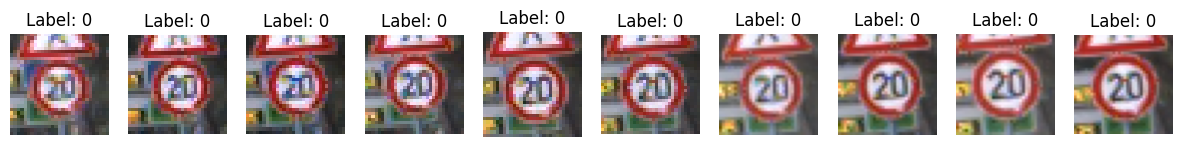

In [21]:
# Eğitim veri setinden birkaç örneği görselleştirme
import matplotlib.pyplot as plt

# Görüntülerin ilk 10 tanesini görselleştirme
# Görsellerin normalize edilmiş değerlerini [0, 1] aralığına çekerek düzeltiyoruz
fig, axes = plt.subplots(1, 10, figsize=(15, 5))  # 1 satır, 5 sütun
for i, ax in enumerate(axes):
   # Görüntüyü yeniden boyutlandır ve normalize etmeden göster
    img = train_data[i][0].permute(1, 2, 0).numpy()  # Tensörü numpy array'e çevir. # Görüntüyü (H, W, C) formatına çevir
    img = (img - img.min()) / (img.max() - img.min())  # Görseli 0-1 aralığına döndür
    ax.imshow(img)  # Görüntüyü göster
    ax.set_title(f"Label: {train_data[i][1]}")  # Etiket ekle
    ax.axis('off')  # Eksenleri kapat
plt.show()


In [22]:
# Etiketlerin dağılımını kontrol etme
import numpy as np
labels = [train_data[i][1] for i in range(len(train_data))]
unique, counts = np.unique(labels, return_counts=True)

print("Sınıf dağılımı:")
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} örnek")

Sınıf dağılımı:
Label 0: 150 örnek
Label 1: 1500 örnek
Label 2: 1500 örnek
Label 3: 960 örnek
Label 4: 1320 örnek
Label 5: 1260 örnek
Label 6: 300 örnek
Label 7: 960 örnek
Label 8: 960 örnek
Label 9: 990 örnek
Label 10: 1350 örnek
Label 11: 900 örnek
Label 12: 1410 örnek
Label 13: 1440 örnek
Label 14: 540 örnek
Label 15: 420 örnek
Label 16: 300 örnek
Label 17: 750 örnek
Label 18: 810 örnek
Label 19: 150 örnek
Label 20: 240 örnek
Label 21: 240 örnek
Label 22: 270 örnek
Label 23: 360 örnek
Label 24: 180 örnek
Label 25: 1020 örnek
Label 26: 420 örnek
Label 27: 180 örnek
Label 28: 360 örnek
Label 29: 180 örnek
Label 30: 300 örnek
Label 31: 540 örnek
Label 32: 180 örnek
Label 33: 480 örnek
Label 34: 300 örnek
Label 35: 810 örnek
Label 36: 270 örnek
Label 37: 150 örnek
Label 38: 1380 örnek
Label 39: 210 örnek
Label 40: 240 örnek
Label 41: 180 örnek
Label 42: 180 örnek


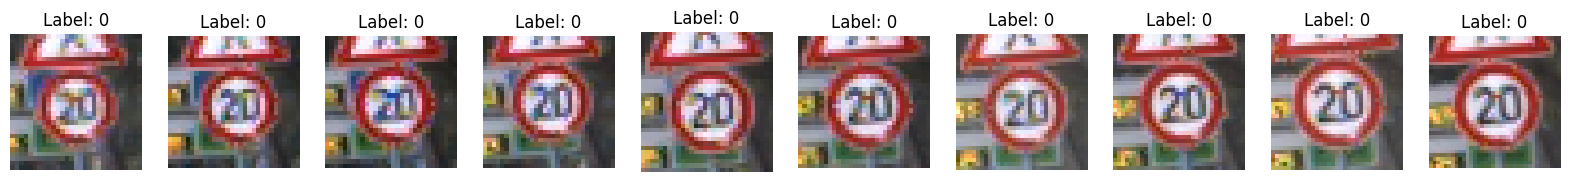

In [23]:
# İlk 10 görüntüyü etiketlerle görselleştirme
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axes):
    img = train_data[i][0].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img)
    ax.set_title(f"Label: {train_data[i][1]}")
    ax.axis('off')
plt.show()


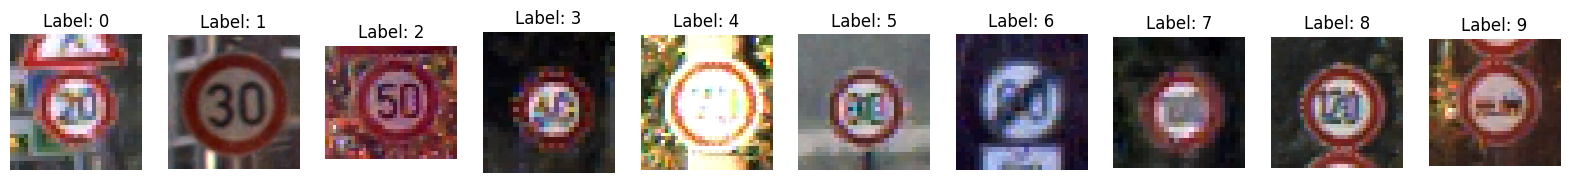

In [24]:
# Farklı 10 sınıftan birer örnek seçip görselleştirme
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
unique_labels = set()
i = 0

for img, label in train_data:
    if label not in unique_labels:
        img = img.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
        unique_labels.add(label)
        i += 1
    if i == 10:  # 10 farklı sınıfı görselleştir
        break
plt.show()


# 2- RBF MODELLERİ

Gerekli kütüphaneler ve kurumları

In [25]:
# Gerekli kütüphaneler
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# RBF Katmanı (Gaussian Aktivasyon Fonksiyonu ile)
class RBFLayer(Layer):
    def __init__(self, units, betas=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.betas = betas

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, input_shape[-1]),
            initializer='random_normal',
            trainable=True
        )
        self.betas = self.add_weight(
            name='betas',
            shape=(self.units,),
            initializer=tf.keras.initializers.Constant(self.betas),
            trainable=True
        )

    def call(self, inputs):
        c = tf.expand_dims(self.centers, axis=0)
        x = tf.expand_dims(inputs, axis=1)
        return tf.exp(-self.betas * tf.reduce_sum(tf.square(x - c), axis=2))

# Eğitim verilerinin giriş boyutunu belirleme
input_dim = X_train_scaled.shape[1]

## RBF MODEL 1 :  Model Eğitimi

In [26]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

# Hedef değişkenleri one-hot encoding formatına dönüştürme
y_train_encoded = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_encoded = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Gaussian RBF aktivasyon fonksiyonu
def gaussian_rbf(x):
    return tf.math.exp(-tf.math.square(x))  # Gaussian fonksiyonu

# RBF Model 1
model1 = Sequential()
model1.add(Dense(10, input_dim=X_train_scaled.shape[1], activation=gaussian_rbf))  # RBF katman
model1.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Çıkış katmanı

# Modeli derleme
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history1 = model1.fit(X_train_scaled, y_train_encoded,
                      validation_data=(X_test_scaled, y_test_encoded),
                      epochs=50, batch_size=32, verbose=1)

# Model performansını değerlendirme
final_accuracy = model1.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"Final Test Accuracy: {final_accuracy[1]}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0525 - loss: 3.6528 - val_accuracy: 0.0588 - val_loss: 3.4489
Epoch 2/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0549 - loss: 3.4366 - val_accuracy: 0.0658 - val_loss: 3.3415
Epoch 3/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0637 - loss: 3.3504 - val_accuracy: 0.0956 - val_loss: 3.3323
Epoch 4/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0800 - loss: 3.3132 - val_accuracy: 0.0884 - val_loss: 3.3031
Epoch 5/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0831 - loss: 3.2780 - val_accuracy: 0.0887 - val_loss: 3.2726
Epoch 6/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0852 - loss: 3.2325 - val_accuracy: 0.0942 - val_loss: 3.2185
Epoch 7/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0827 - loss: 3.2079 - val_accuracy: 0.0907 - val_loss: 3.2549
Epoch 8/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0873 - loss: 3.1943 - val_accuracy: 0.

## RBF MODEL 1 : RandomSearchCV ile Hiperparametre Optimizasyonu ve Performans Grafikleri

In [27]:
!pip install --upgrade tensorflow scikit-learn
!pip install scikeras
!pip install --upgrade pip
!pip install --upgrade tensorflow scikit-learn

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RBF Model 1 - En iyi hiperparametreler: {'model__optimizer': 'adam', 'model__neurons': 5, 'epochs': 100, 'batch_size': 64}
RBF Model 1 - En iyi doğruluk skoru (cv): 0.0018393393393393393
RBF Model 1 - Test Doğruluğu: 0.05708630245447348
Epoch 1/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0557 - loss: 3.4973 - val_accuracy: 0.0564 - val_loss: 3.4635
Epoch 2/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0547 - loss: 3.4909 - val_accuracy: 0.0570 - val_loss: 3.4644
Epoch 3/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0579 - loss: 3.4896 - val_accuracy: 0.0599 - val_loss: 3.4656
Epoch 4/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0572 - loss: 3.4927 - val_accuracy: 0.0564 - val_loss: 3.4643
Epoch 5/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0561 - loss: 3.4968 - val_accuracy: 0.0599 - val_loss: 3.4639
Epoch 6/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - ac

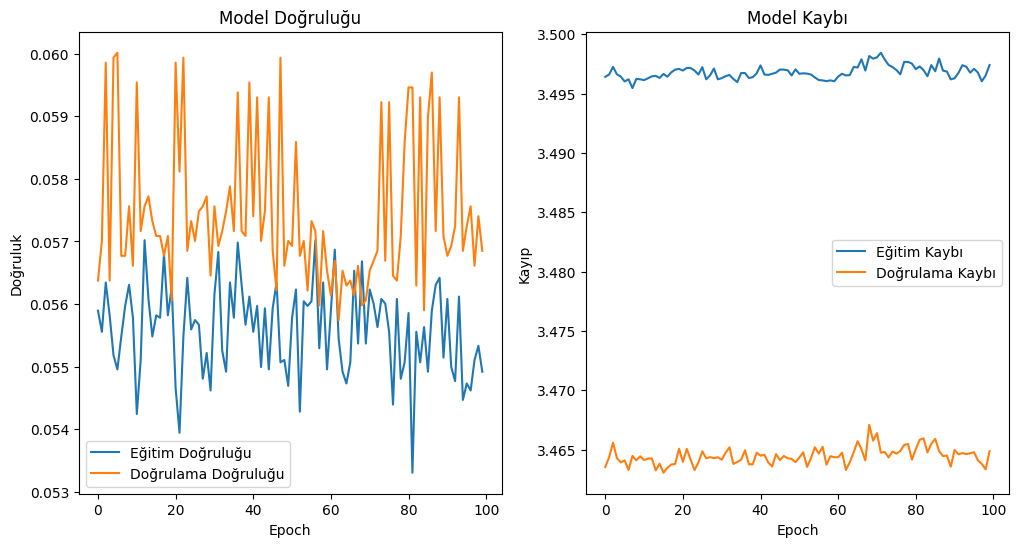

In [28]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import History
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Gaussian RBF aktivasyon fonksiyonu
def gaussian_rbf(x):
    return tf.math.exp(-tf.math.square(x))  # Gaussian fonksiyonu

# RBF Model 1'i oluşturan bir fonksiyon
def create_rbf_model(neurons=10, optimizer='adam'):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),  # Giriş boyutu
        Dense(neurons, activation=gaussian_rbf),  # RBF katmanı
        Dense(len(np.unique(y_train)), activation='softmax')  # Çıkış katmanı
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hedef verileri one-hot encoding formatına dönüştürme
y_train_encoded = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_encoded = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# KerasClassifier ile modelimizi scikit-learn uyumlu hale getirme
model = KerasClassifier(model=create_rbf_model, verbose=0)

# Hiperparametre aralıkları
param_dist_rbf1 = {
    'model__neurons': [5, 10, 20, 50],          # RBF katmanındaki nöron sayısı
    'model__optimizer': ['adam', 'rmsprop'],    # Optimizasyon algoritmaları
    'batch_size': [16, 32, 64],                 # Batch boyutları
    'epochs': [50, 100]                         # Epoch sayısı
}

# RandomizedSearchCV tanımlama
random_search_rbf1 = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist_rbf1,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Modeli eğitme
history = random_search_rbf1.fit(X_train_scaled, y_train_encoded)

# En iyi hiperparametreleri ve sonuçları yazdırma
print("RBF Model 1 - En iyi hiperparametreler:", random_search_rbf1.best_params_)
print("RBF Model 1 - En iyi doğruluk skoru (cv):", random_search_rbf1.best_score_)

# Test setindeki performansı değerlendirme
final_accuracy_rbf1 = random_search_rbf1.best_estimator_.score(X_test_scaled, y_test_encoded)
print(f"RBF Model 1 - Test Doğruluğu: {final_accuracy_rbf1}")

# History callback kullanarak eğitim sürecini kaydetme
best_model = random_search_rbf1.best_estimator_.model_
history = best_model.fit(
    X_train_scaled,
    y_train_encoded,
    validation_data=(X_test_scaled, y_test_encoded),
    epochs=random_search_rbf1.best_params_['epochs'],
    batch_size=random_search_rbf1.best_params_['batch_size'],
    verbose=1
)

# Eğitim ve doğrulama metriklerini çizdirme
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()


**Sonuç olarak;**
Model Doğruluğu: Eğitim ve doğrulama doğruluğu 0.05 (yaklaşık %5) civarında sabit kalmış, bu çok düşük bir değer. Model, veri setinde anlamlı bir öğrenme gerçekleştirememiş gibi görünüyor. Eğitim doğruluğu ile doğrulama doğruluğu arasında büyük bir fark yok, bu da modelin aşırı öğrenme yapmadığını, ancak yeterince iyi öğrenemediğini bize gösteriyor.

Model Kaybı: Eğitim ve doğrulama kayıpları (loss) grafikleri neredeyse düz bir çizgi oluşturuyor ve kayıp değerleri yüksek seviyelerde sabit kalmış. Bu da modelin optimizasyon sırasında sıkışmış olabileceğini ve daha iyi bir minimuma ulaşamadığını  bizegösteriyor.

Modelin doğruluğu ve kayıp değerleri, modelin mevcut ayarlarla karmaşık yapıyı öğrenmekte zorlandığını işaret ediyor. Gaussian RBF katmanında kullanılan hiperparametreleri (nöron sayısı, optimizasyon algoritması vb.) ve veri ön işleme adımlarını yeniden gözden geçirmeliyiz.

Optimizasyon parametrelerini değiştirebiliriz, model karmaşıklığını artırabiliriz, erken durdurma kullanabiliriz. Bu şekilde hiperparametreler, veri ön işleme ve model yapısı iyileştirilmesi gereklidir. Örneğin, daha fazla nöron, farklı optimizasyon algoritmaları veya daha düşük öğrenme oranı kullanabiliriz.

## NOT: Model 1'in İlk Hali ve RandomizedSearchCV ile Optimize Edilmiş Hali Arasındaki Fark:

Performans: İlk modelin test doğruluğu %8.6 civarında olup, doğrulama doğruluğu ve kayıp değerleri arasındaki fark minimaldir. Ancak genel olarak performansı çok düşüktür.

Optimizasyon Sonrası: Optimizasyon sonrası modelin doğruluğu %5.7 ile daha da düşmüştür, yani optimizasyon model performansını artırmamıştır.

Öğrenme Durumu: İlk model başlangıçta bir miktar öğrenme gösterse de, 50 epoch sonrasında doğrulukta anlamlı bir artış sağlanamamış ve kayıp değerleri belirgin bir iyileşme göstermemiştir. Optimizasyon sonrası modelin kayıp değerleri 3.46 civarında sabitlenmiş ve hiçbir öğrenme gerçekleşmemiştir. Doğruluk aynı seviyelerde kalmıştır.

Hiperparametre Etkisi: İlk model varsayılan hiperparametreler ile modelin performansı düşük ama öğrenme izleri vardı. Optimizasyon Sonrası: Seçilen hiperparametreler (örneğin, düşük nöron sayısı ve learning rate) öğrenmeyi daha da sınırlamış ve modelin performansını daha kötü hale getirmiştir.

Eğitim Süreci: İlk model doğrulama doğruluğunda küçük dalgalanmalar ve başlangıçta sınırlı da olsa öğrenme izlenmiştir. Optimizasyon Sonrası: Model tamamen öğrenemez hale gelmiş, doğruluk ve kayıp değerleri sabit kalmıştır.

Sonuç: Optimizasyon hiperparametre seçimindeki hatalardan dolayı modelin performansını daha kötü hale getirdiğini görmekteyiz. Özellikle nöron sayısının düşük olması ve yanlış optimizer seçimi modelin kapasitesini sınırlamıştır.

## RBF MODEL 1:  Model Karışıklık Matrisi

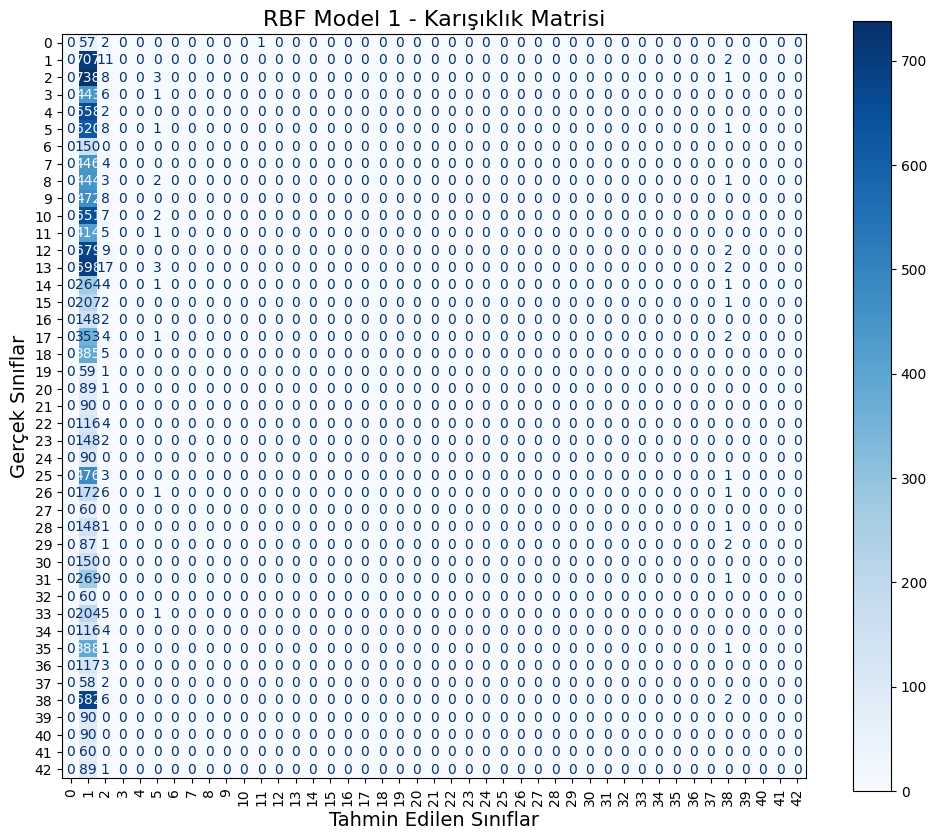

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Test seti üzerinde tahminler yap
y_pred_encoded = random_search_rbf1.best_estimator_.predict(X_test_scaled)

# One-hot encoded sınıfları argmax ile geri dönüştür
y_test_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred_encoded, axis=1)

# Karışıklık matrisini hesapla
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Karışıklık matrisini görselleştir
fig, ax = plt.subplots(figsize=(12, 10))  # Daha büyük boyutlar için figsize parametresi ayarlandı
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', colorbar=True)

plt.title("RBF Model 1 - Karışıklık Matrisi", fontsize=16)
plt.xlabel("Tahmin Edilen Sınıflar", fontsize=14)
plt.ylabel("Gerçek Sınıflar", fontsize=14)
plt.show()


**Sonuç olarak:**

•	Model, tahminlerinin büyük bir kısmını belirli birkaç sınıfa odaklamış ve diğer sınıfları neredeyse hiç doğru tahmin edememiş. Bu durum, modelin ciddi şekilde dengesiz bir öğrenme gerçekleştirdiğini veya belirli sınıflara aşırı uyum sağladığını bize gösteriyor.

•	Sonuç olarak: Özellikle, veri dengesizliği, modelin karmaşıklığının yeterli olmaması veya hiperparametre seçiminin etkisiz olması bu sorunun nedeni olabilir. Daha dengeli bir performans için veri ön işleme, sınıf ağırlıklandırması veya model yapılandırmasını yeniden gözden geçirmeliyiz.

## RBF MODEL 2 :  Model Eğitimi

In [30]:
# RBF Model 2
model2 = Sequential()
model2.add(Dense(50, input_dim=X_train_scaled.shape[1], activation=gaussian_rbf))  # İlk RBF katmanı
model2.add(Dense(30, activation='relu'))  # İkinci gizli katman
model2.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Çıkış katmanı

# Modeli derleme
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history2 = model2.fit(X_train_scaled, y_train_encoded,
                      validation_data=(X_test_scaled, y_test_encoded),
                      epochs=50, batch_size=32, verbose=1)

# Model performansını değerlendirme
final_accuracy2 = model2.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"Final Test Accuracy: {final_accuracy2[1]}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.0520 - loss: 3.6026 - val_accuracy: 0.0523 - val_loss: 3.4670
Epoch 2/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.0662 - loss: 3.4938 - val_accuracy: 0.0633 - val_loss: 3.4668
Epoch 3/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.0615 - loss: 3.4925 - val_accuracy: 0.0615 - val_loss: 3.4657
Epoch 4/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0622 - loss: 3.4909 - val_accuracy: 0.0611 - val_loss: 3.4670
Epoch 5/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.0625 - loss: 3.4815 - val_accuracy: 0.0631 - val_loss: 3.4649
Epoch 6/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0629 - loss: 3.4850 - val_accuracy: 0.0562 - val_loss: 3.4649
Epoch 7/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0658 - loss: 3.4801 - val_accuracy: 0.0611 - val_loss: 3.4677
Epoch 8/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.0607 - loss: 3.4847 - val_accura

## RBF MODEL 2 : RandomSearchCV ile Hiperparametre Optimizasyonu ve Performans Grafikleri

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RBF Model 2 - En iyi hiperparametreler: {'model__optimizer': 'rmsprop', 'model__neurons2': 30, 'model__neurons1': 20, 'model__learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16}
RBF Model 2 - En iyi doğruluk skoru (cv): 0.00533033033033033
RBF Model 2 - Test Doğruluğu: 0.7000792026519775
Epoch 1/100
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9285 - loss: 0.2620 - val_accuracy: 0.6773 - val_loss: 1.6258
Epoch 2/100
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9305 - loss: 0.2560 - val_accuracy: 0.7229 - val_loss: 1.3999
Epoch 3/100
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9295 - loss: 0.2604 - val_accuracy: 0.6728 - val_loss: 1.6436
Epoch 4/100
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9301 - loss: 0.2586 - val_accuracy: 0.6908 - val_loss: 1.5763
Epoch 5/100
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9315 - loss: 0.2452 - val_accuracy: 0.7042 - val_lo

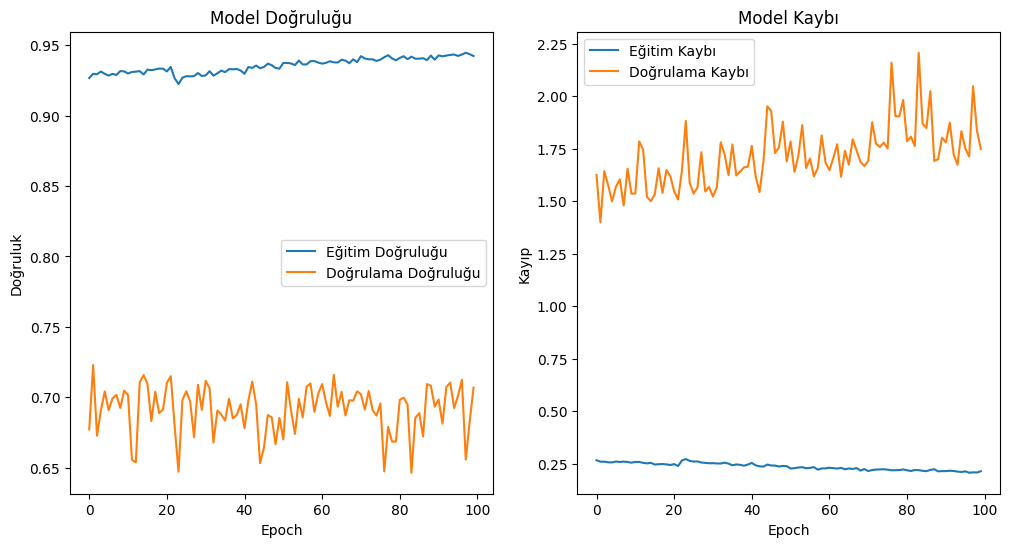

In [31]:
from scikeras.wrappers import KerasClassifier  # scikeras kullanımı
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Gaussian RBF aktivasyon fonksiyonu
def gaussian_rbf(x):
    return tf.math.exp(-tf.math.square(x))  # Gaussian fonksiyonu

# Modeli oluşturan bir fonksiyon
def create_rbf_model2(neurons1=50, neurons2=30, optimizer='adam', learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),  # Girdi katmanı
        Dense(neurons1, activation=gaussian_rbf),  # İlk RBF katmanı
        Dense(neurons2, activation='relu'),       # İkinci gizli katman
        Dense(len(np.unique(y_train)), activation='softmax')  # Çıkış katmanı
    ])
    optimizer_instance = Adam(learning_rate=learning_rate) if optimizer == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hedef verileri one-hot encoding formatına dönüştürme
y_train_encoded = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_encoded = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# KerasClassifier ile modelimizi scikit-learn uyumlu hale getirme
model = KerasClassifier(model=create_rbf_model2, verbose=0)

# Hiperparametre aralıkları
param_dist_rbf2 = {
    'model__neurons1': [20, 50, 100],          # İlk RBF katmanındaki nöron sayısı
    'model__neurons2': [10, 30, 50],           # İkinci gizli katmandaki nöron sayısı
    'model__optimizer': ['adam'],   # Optimizasyon algoritmaları
    'model__learning_rate': [0.001, 0.0001],   # Öğrenme oranları
    'batch_size': [16, 32, 64],                # Batch boyutları
    'epochs': [50, 100],                       # Epoch sayısı
}

# RandomizedSearchCV tanımlama
random_search_rbf2 = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist_rbf2,
    n_iter=5,  # Rastgele 5 farklı kombinasyon dene
    cv=3,       # 3 katlı çapraz doğrulama
    scoring='accuracy',
    verbose=2,
    n_jobs=-1   # Paralel işlem
)

# Modeli eğitme
history = random_search_rbf2.fit(X_train_scaled, y_train_encoded)

# En iyi hiperparametreleri ve sonuçları yazdırme
print("RBF Model 2 - En iyi hiperparametreler:", random_search_rbf2.best_params_)
print("RBF Model 2 - En iyi doğruluk skoru (cv):", random_search_rbf2.best_score_)

# En iyi modeli seç ve test performansını değerlendirme
best_model = random_search_rbf2.best_estimator_.model_
final_accuracy_rbf2 = best_model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"RBF Model 2 - Test Doğruluğu: {final_accuracy_rbf2[1]}")

# Modelin eğitim sürecini kaydetme
history = best_model.fit(
    X_train_scaled,
    y_train_encoded,
    validation_data=(X_test_scaled, y_test_encoded),
    epochs=random_search_rbf2.best_params_['epochs'],
    batch_size=random_search_rbf2.best_params_['batch_size'],
    verbose=1
)

# Eğitim ve doğrulama metriklerini çizdirme
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()


**Sonuç olarak:**
Bu model, %70 doğruluk oranıyla önceki modele kıyasla çok daha başarılı bir performans sergiliyor. Eğitim doğruluğu ve kaybı iyi görünüyor; ancak, doğrulama doğruluğu ile eğitim doğruluğu arasındaki fark, bir miktar overfitting anlamına gelebilir.

o	Eğitim sırasında doğrulama kaybında dalgalanmalar var. Bu, modelin stabilizasyon sorunları yaşadığını gösterebiliyor.

o	Eğitim doğruluğu yüksek (%94 civarında), ancak doğrulama doğruluğu (%70 civarında) bu kadar iyi değil.

o	Overfitting’i azaltmak için düzenleme teknikleri (dropout, erken durdurma) veya daha fazla veriyle yeniden eğitim deneyebiliriz.
Genel olarak, bu model mevcut hiperparametrelerle görevde makul bir başarı yakalamadığını görmekteyiz..



**Grafikler:** Model eğitim verisinde yüksek doğruluk (%95) elde ediyor, ancak doğrulama setinde dalgalı ve düşük doğruluk (%65-75) gösteriyor. Bu durum overfitting olduğunu bize ifade ediyor. Eğitim kaybı düzenli azalırken, doğrulama kaybı dalgalı ve yüksek seyrediyor. Overfitting'i azaltmak için Dropout, erken durdurma veya veri artırma gibi yöntemler kullanabilir ve modeli yeniden deneyebiliriz.

## NOT: Model 2'nin İlk Hali ve RandomizedSearchCV ile Optimize Edilmiş Hali Arasındaki Fark:

Performans: İlk modelin test doğruluğu %5.5 ile çok düşük seviyelerde kalırken, optimizasyon sonrası %70.0'a yükselmiştir. Doğrulama doğruluğu da optimizasyon sonrası belirgin bir şekilde artış gözlemlenmiştir.

Eğitim Kaybı:İlk modelde kayıp 3.48 seviyelerinde takılı kalmış, öğrenme gerçekleşmemiştir. Optimizasyon sonrası kayıp değerleri 0.2-0.25 aralığına düşmüş ve öğrenme iyileşmemiş olduğunu görmekteyiz.

Hiperparametreler: İlk model: Hatalı hiperparametre seçimi (ör. learning rate) nedeniyle düşük performans göstermiştir. Optimizasyon sonrası: Daha iyi hiperparametreler (learning rate: 0.0001, batch size: 16) ile model öğrenebilir hale geldiği görülmektedir.

Eğitim Süreci: İlk modelde doğrulama doğruluğu ve kayıp değerlerinde iyileşme olmamış, model sabit kalmıştır. Optimizasyon sonrası doğrulama doğruluğu sürekli iyileşme göstermiş ve model performansı artmıştır.

Sonuç: Optimizasyon, modelin öğrenme kapasitesini artırmış ve doğruluğunu önemli ölçüde iyileştirmiştir.

## RBF MODEL 2 : Karışıklık Matrisi

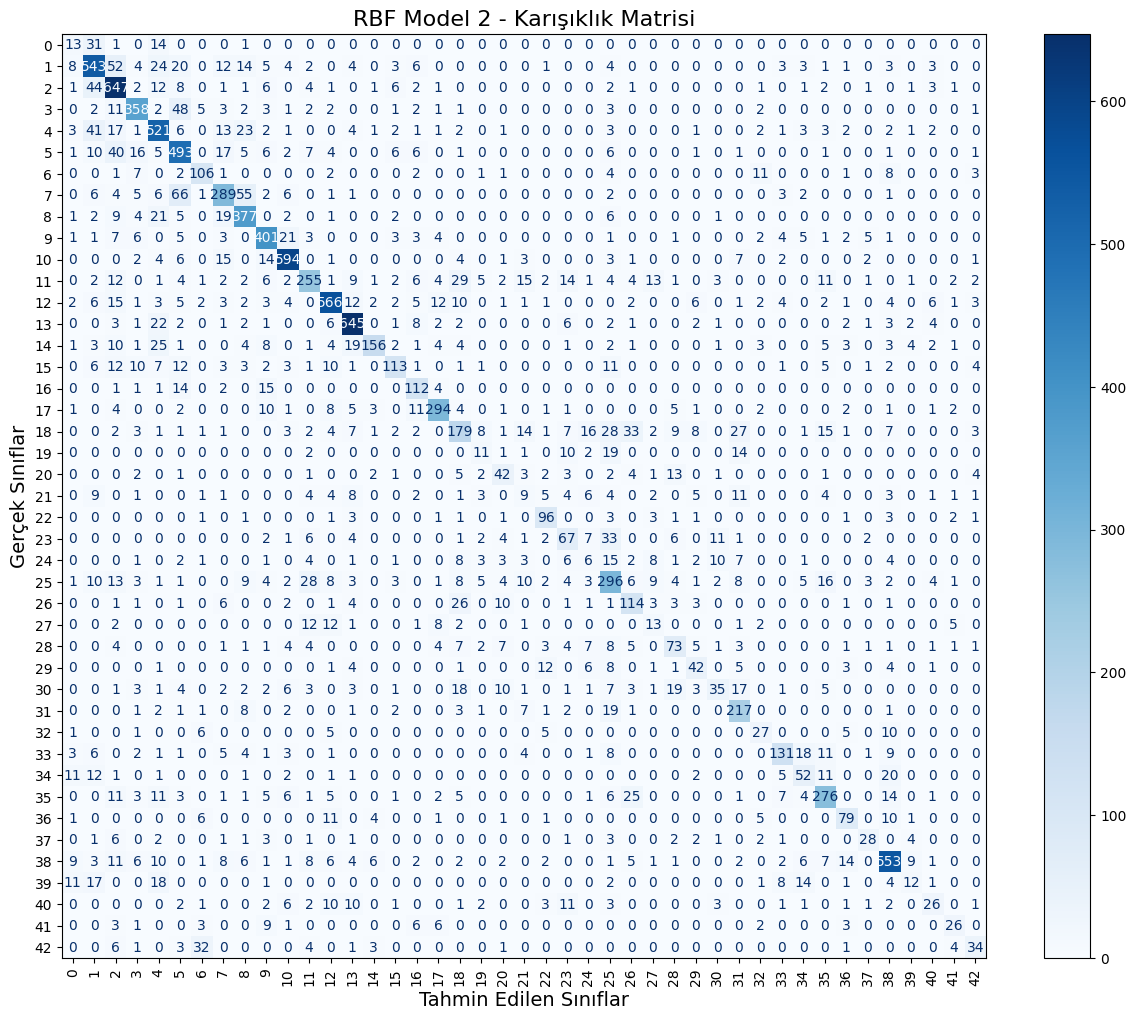

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Test seti üzerinde tahminler yap
y_pred_encoded = random_search_rbf2.best_estimator_.predict(X_test_scaled)

# One-hot encoded sınıfları argmax ile geri dönüştür
y_test_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred_encoded, axis=1)

# Karışıklık matrisini hesapla
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Karışıklık matrisini görselleştir
fig, ax = plt.subplots(figsize=(15, 12))  # Boyutları biraz daha büyük ayarlandı
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', colorbar=True)

plt.title("RBF Model 2 - Karışıklık Matrisi", fontsize=16)
plt.xlabel("Tahmin Edilen Sınıflar", fontsize=14)
plt.ylabel("Gerçek Sınıflar", fontsize=14)
plt.show()


**Sonuç olarak:**

 RBF Model 2 modelinin bazı sınıflarda iyi tahminler yaptığını (örneğin, 1, 9, 13, 14) ancak diğer sınıflarda düşük performans gösterdiğini (örneğin, 10, 16, 29) bize gösteriyor. Model özellikle yakın sınıflar arasında karışıklık yaşıyor ve genel performansı sınıf dengesizliklerinden etkilenmiş olabilir. Daha iyi veri dengesi, model yapısının iyileştirilmesi veya hiperparametre optimizasyonuyla modelimizin performansını artırmayı deneyebiliriz.

## RBF MODEL 3 :  Model Eğitimi

In [34]:
# RBF Model 3
model3 = Sequential()
model3.add(Dense(20, input_dim=X_train_scaled.shape[1], activation=gaussian_rbf))  # Gaussian RBF
model3.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Çıkış katmanı

# Modeli derleme
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history3 = model3.fit(X_train_scaled, y_train_encoded,
                      validation_data=(X_test_scaled, y_test_encoded),
                      epochs=50, batch_size=32, verbose=1)

# Model performansını değerlendirme
final_accuracy3 = model3.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"Final Test Accuracy: {final_accuracy3[1]}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0512 - loss: 3.6862 - val_accuracy: 0.0555 - val_loss: 3.5462
Epoch 2/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0541 - loss: 3.5442 - val_accuracy: 0.0530 - val_loss: 3.4933
Epoch 3/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0505 - loss: 3.5117 - val_accuracy: 0.0563 - val_loss: 3.4770
Epoch 4/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0554 - loss: 3.5074 - val_accuracy: 0.0538 - val_loss: 3.4707
Epoch 5/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0554 - loss: 3.4944 - val_accuracy: 0.0549 - val_loss: 3.4674
Epoch 6/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0563 - loss: 3.4999 - val_accuracy: 0.0546 - val_loss: 3.4647
Epoch 7/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0576 - loss: 3.4978 - val_accuracy: 0.0568 - val_loss: 3.4652
Epoch 8/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0571 - loss: 3.4926 - val_accuracy: 0.

## RBF MODEL 3 : RandomSearchCV ile Hiperparametre Optimizasyonu ve Performans Grafikleri

Fitting 3 folds for each of 5 candidates, totalling 15 fits
RBF Model 3 - En iyi hiperparametreler: {'model__optimizer': 'adam', 'model__neurons': 20, 'model__learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32}
RBF Model 3 - En iyi doğruluk skoru (cv): 0.008370870870870871
RBF Model 3 - Test Doğruluğu: 0.7561361789703369
Epoch 1/100
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9465 - loss: 0.3098 - val_accuracy: 0.7650 - val_loss: 0.9559
Epoch 2/100
833/833 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9486 - loss: 0.3078 - val_accuracy: 0.7731 - val_loss: 0.9342
Epoch 3/100
833/833 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9492 - loss: 0.2967 - val_accuracy: 0.7662 - val_loss: 0.9539
Epoch 4/100
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9498 - loss: 0.2953 - val_accuracy: 0.7694 - val_loss: 0.9426
Epoch 5/100
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9522 - loss: 0.2888 - val_accuracy: 0.7647 - val_loss: 0.9406
Epoch 6/100
833/833 ━━━━━━

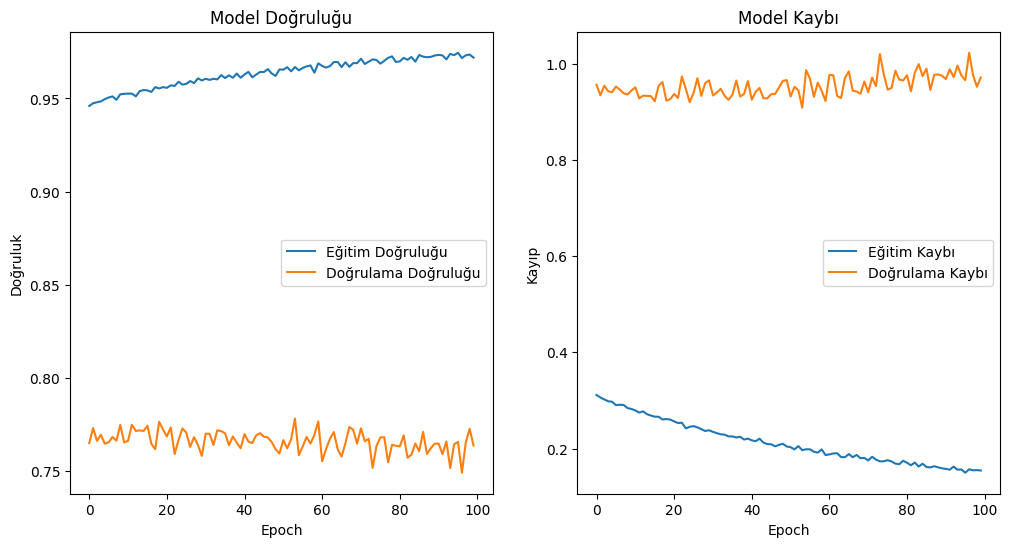

In [35]:
from scikeras.wrappers import KerasClassifier  # scikeras kullanımı
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Gaussian RBF aktivasyon fonksiyonu
def gaussian_rbf(x):
    return tf.math.exp(-tf.math.square(x))  # Gaussian fonksiyonu

# RBF Model 3'ü oluşturan bir fonksiyon
def create_rbf_model3(neurons=20, optimizer='adam', learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),  # Giriş katmanı
        Dense(neurons, activation=gaussian_rbf),  # Gaussian RBF katmanı
        Dense(len(np.unique(y_train)), activation='softmax')  # Çıkış katmanı
    ])
    optimizer_instance = Adam(learning_rate=learning_rate) if optimizer == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hedef verileri one-hot encoding formatına dönüştürme
y_train_encoded = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_encoded = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# KerasClassifier ile modelimizi scikit-learn uyumlu hale getirme
model = KerasClassifier(model=create_rbf_model3, verbose=0)

# Hiperparametre aralıkları
param_dist_rbf3 = {
    'model__neurons': [10, 20, 50],            # Gaussian RBF katmanındaki nöron sayısı
    'model__optimizer': ['adam'],   # Optimizasyon algoritmaları
    'model__learning_rate': [0.001, 0.0001],   # Öğrenme oranları
    'batch_size': [16, 32, 64],                # Batch boyutları
    'epochs': [50, 100],                       # Epoch sayısı
}

# RandomizedSearchCV tanımlama
random_search_rbf3 = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist_rbf3,
    n_iter=5,  # Rastgele 5 farklı kombinasyon dene
    cv=3,       # 3 katlı çapraz doğrulama
    scoring='accuracy',
    verbose=2,
    n_jobs=-1   # Paralel işlem
)

# Modeli eğitme
random_search_rbf3.fit(X_train_scaled, y_train_encoded)

# En iyi hiperparametreleri ve sonuçları yazdırma
print("RBF Model 3 - En iyi hiperparametreler:", random_search_rbf3.best_params_)
print("RBF Model 3 - En iyi doğruluk skoru (cv):", random_search_rbf3.best_score_)

# En iyi modeli seç ve test performansını değerlendirme
best_model = random_search_rbf3.best_estimator_.model_
final_accuracy_rbf3 = best_model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"RBF Model 3 - Test Doğruluğu: {final_accuracy_rbf3[1]}")

# Modelin eğitim sürecini kaydetme
history = best_model.fit(
    X_train_scaled,
    y_train_encoded,
    validation_data=(X_test_scaled, y_test_encoded),
    epochs=random_search_rbf3.best_params_['epochs'],
    batch_size=random_search_rbf3.best_params_['batch_size'],
    verbose=1
)

# Eğitim ve doğrulama metriklerini çizdirme
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()


**Sonuç olarak:**
Eğitim Doğruluğu: Model, eğitim setinde oldukça yüksek doğruluk oranlarına (%97 civarı) ulaşmıştır. Bu, modelin eğitim verisini iyi öğrendiğini gösteriyor.

Doğrulama Doğruluğu: Doğrulama setinde doğruluk daha düşük (%75-77) ve dalgalı. Bu durum overfitting (aşırı öğrenme) yaptığını bize gösterebilir.

Kaybın Azalması: Eğitim kaybı düzenli azalırken, doğrulama kaybı daha dalgalı bir seyir izliyor ve belirli bir seviyede sabitlenmiyor.
Sonuç: Model eğitim verisine aşırı odaklanmış gibi görünüyor ve doğrulama performansı sınırlı. Overfitting'i önlemek için erken durdurma, dropout, veya veri artırma gibi yöntemler kullanabiliriz. Doğrulama doğruluğunu iyileştirirsek, model genelleme kapasitesi de bu doğrultuda artacaktır.


## NOT: Model 3'ün İlk Hali ve RandomizedSearchCV ile Optimize Edilmiş Hali Arasındaki Fark:

Performans: İlk modelin test doğruluğu %6.1 ile çok düşük kalırken, optimizasyon sonrası %75.6'ya ulaşmıştır.Doğrulama doğruluğu optimizasyon sonrası %76 civarında dengelenmiş olduğunu görmekteyiz.

Eğitim Kaybı: İlk modelde eğitim kaybı 3.5 seviyelerinde takılmış ve anlamlı bir iyileşme sağlanamamıştır.Optimizasyon sonrası kayıp 0.15-0.30 aralığına düşmüş, modelimiz öğrenebilir hale gelmiştir.

Hiperparametreler: Optimizasyon öncesi model kötü seçilmiş hiperparametrelerle (ör. learning rate, batch size) başarısızdır. Optimizasyon sonrası, daha uygun hiperparametrelerle (batch size: 32, learning rate: 0.0001) model verimli hale getirildi.

Eğitim Süreci: İlk modelde val_accuracy ve val_loss'ta anlamlı değişiklikler olmamıştır. Optimizasyon sonrası doğrulama kaybı ve doğruluk sürekli iyileşmiştir.

Sonuç: Optimizasyon, öğrenme sürecini düzeltmiş ve model performansını belirgin şekilde artırdığınızı bize göstermektedir.

## RBF MODEL 3 :  Karışıklık Matrisi

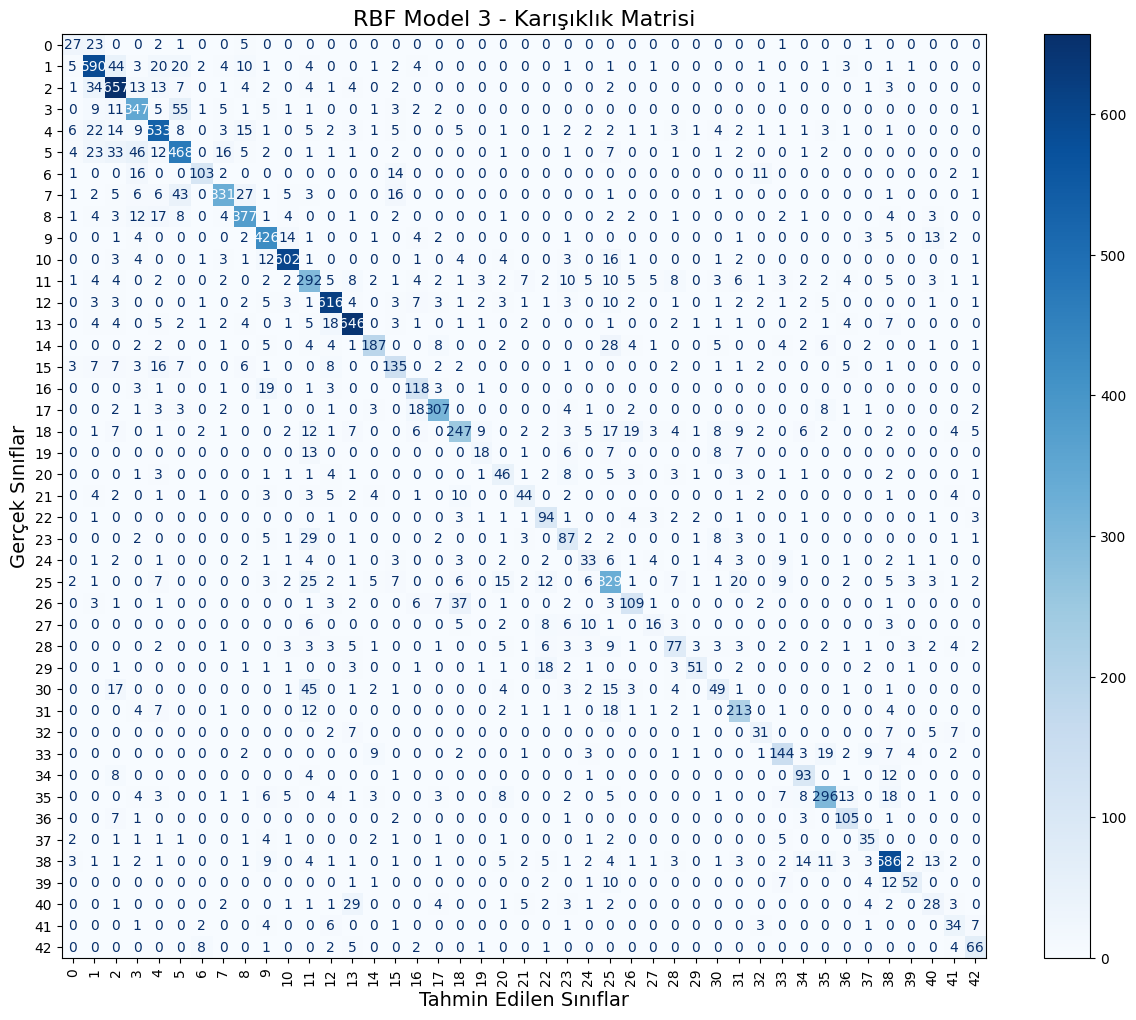

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Test seti üzerinde tahminler yap
y_pred_encoded = random_search_rbf3.best_estimator_.predict(X_test_scaled)

# One-hot encoded sınıfları argmax ile geri dönüştür
y_test_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred_encoded, axis=1)

# Karışıklık matrisini hesapla
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Karışıklık matrisini görselleştir
fig, ax = plt.subplots(figsize=(15, 12))  # Boyutları biraz daha büyük ayarlandı
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', colorbar=True)

plt.title("RBF Model 3 - Karışıklık Matrisi", fontsize=16)
plt.xlabel("Tahmin Edilen Sınıflar", fontsize=14)
plt.ylabel("Gerçek Sınıflar", fontsize=14)
plt.show()


**Sonuç olarak:**

RBF Model 3 modeli belirli sınıflarda (örneğin, 1, 9, 13, 14, 28) başarılı tahminler yaptığını, ancak bazı sınıflarda tahmin performansının düşük olduğunu (örneğin, 10, 16, 33) bize gösteriyor. Model genel olarak doğru sınıflarda yoğunlaşmış, ancak az sayıda örnek bulunan sınıflarda hatalar daha fazla görülmektedir. Modelin performansını artırmak için veri dengesi sağlanabilir veya daha karmaşık bir model yapısı kullanılabilir ve modelimizin performansını artırmayı deneyebiliriz.

## RBF MODEL 4 :  Model Eğitimi

In [37]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
import numpy as np

# Gaussian RBF aktivasyon fonksiyonu (TensorFlow kullanımı ile)
def gaussian_rbf(x):
    return tf.math.exp(-tf.math.square(x))  # e^(-x^2)

# RBF Model 4
rbf_model3 = Sequential()

# Girdi katmanı + RBF katmanı
rbf_model3.add(Dense(128, input_dim=X_train_scaled.shape[1], activation=gaussian_rbf))  # 128 nöronlu RBF katmanı

# Ek Dense katmanları
rbf_model3.add(Dense(64, activation='relu'))
rbf_model3.add(Dense(32, activation='relu'))

# Çıkış katmanı
rbf_model3.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Sınıf sayısına göre çıkış

# Modeli derleme
rbf_model3.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Modeli eğitme
history_rbf3 = rbf_model3.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,  # Daha uzun bir eğitim süresi
    batch_size=128,  # Batch boyutu artırıldı
    verbose=1
)

# Model performansını değerlendirme
final_accuracy_rbf3 = rbf_model3.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Final Test Accuracy: {final_accuracy_rbf3[1]}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.0815 - loss: 3.6373 - val_accuracy: 0.1307 - val_loss: 3.4236
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.1985 - loss: 3.1897 - val_accuracy: 0.2606 - val_loss: 2.9320
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3911 - loss: 2.6190 - val_accuracy: 0.3865 - val_loss: 2.4891
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5381 - loss: 2.0722 - val_accuracy: 0.4798 - val_loss: 2.1374
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6226 - loss: 1.6793 - val_accuracy: 0.5429 - val_loss: 1.8693
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6905 - loss: 1.3758 - val_accuracy: 0.5761 - val_loss: 1.7133
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7487 - loss: 1.1498 - val_accuracy: 0.6067 - val_loss: 1.5599
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7898 - loss: 0.9775 - 

## RBF MODEL 4 : RandomSearchCV ile Hiperparametre Optimizasyonu ve Performans Grafikleri

Fitting 3 folds for each of 5 candidates, totalling 15 fits
RBF Model 4 - En iyi hiperparametreler: {'model__optimizer': 'adam', 'model__neurons3': 32, 'model__neurons2': 64, 'model__neurons1': 128, 'model__learning_rate': 0.0001, 'epochs': 50, 'batch_size': 128}
RBF Model 4 - En iyi doğruluk skoru (cv): 0.006118618618618618
RBF Model 4 - Test Doğruluğu: 0.7192398905754089
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9896 - loss: 0.0659 - val_accuracy: 0.7347 - val_loss: 1.1074
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9902 - loss: 0.0584 - val_accuracy: 0.7353 - val_loss: 1.1067
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9882 - loss: 0.0647 - val_accuracy: 0.7249 - val_loss: 1.2026
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9803 - loss: 0.0888 - val_accuracy: 0.7264 - val_loss: 1.1408
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9900 - loss: 0.0613 - val_accuracy: 0.727

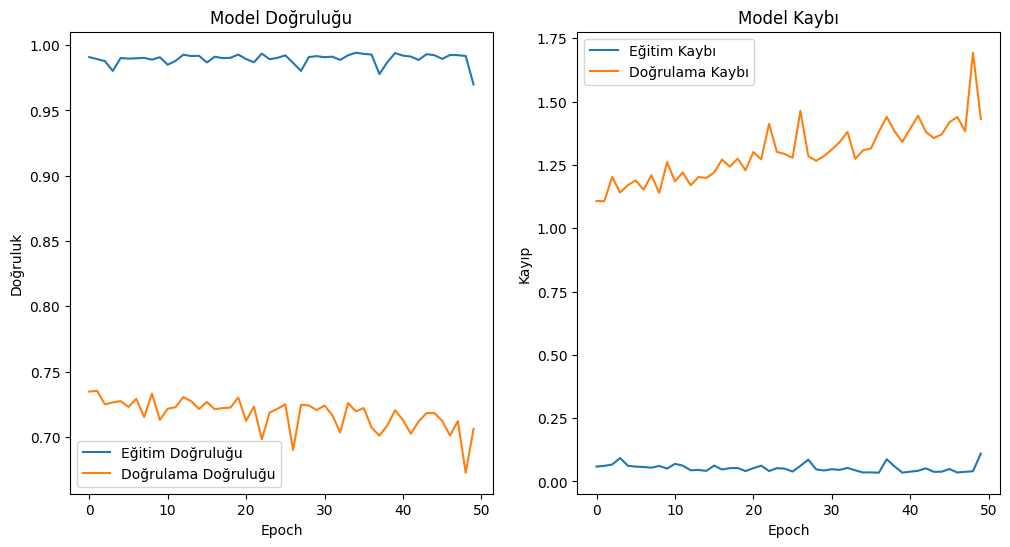

In [38]:
from scikeras.wrappers import KerasClassifier  # scikeras kullanımı
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Gaussian RBF aktivasyon fonksiyonu
def gaussian_rbf(x):
    return tf.math.exp(-tf.math.square(x))  # Gaussian fonksiyonu

# RBF Model 4'ü oluşturan bir fonksiyon
def create_rbf_model4(neurons1=128, neurons2=64, neurons3=32, optimizer='adam', learning_rate=0.0001):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),  # Girdi katmanı
        Dense(neurons1, activation=gaussian_rbf),  # İlk RBF katmanı
        Dense(neurons2, activation='relu'),       # İkinci gizli katman
        Dense(neurons3, activation='relu'),       # Üçüncü gizli katman
        Dense(len(np.unique(y_train)), activation='softmax')  # Çıkış katmanı
    ])
    optimizer_instance = Adam(learning_rate=learning_rate) if optimizer == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hedef verileri one-hot encoding formatına dönüştürme
y_train_encoded = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_encoded = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# KerasClassifier ile modelimizi scikit-learn uyumlu hale getirme
model = KerasClassifier(model=create_rbf_model4, verbose=0)

# Hiperparametre aralıkları
param_dist_rbf4 = {
    'model__neurons1': [64, 128, 256],         # İlk RBF katmanındaki nöron sayısı
    'model__neurons2': [32, 64, 128],          # İkinci gizli katmandaki nöron sayısı
    'model__neurons3': [16, 32, 64],           # Üçüncü gizli katmandaki nöron sayısı
    'model__optimizer': ['adam'],   # Optimizasyon algoritmaları
    'model__learning_rate': [0.001, 0.0001],   # Öğrenme oranları
    'batch_size': [32, 64, 128],               # Batch boyutları
    'epochs': [50, 100],                       # Epoch sayısı
}

# RandomizedSearchCV tanımlama
random_search_rbf4 = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist_rbf4,
    n_iter=5,  # Rastgele 10 farklı kombinasyon dene
    cv=3,       # 3 katlı çapraz doğrulama
    scoring='accuracy',
    verbose=2,
    n_jobs=-1   # Paralel işlem
)

# Modeli eğit
random_search_rbf4.fit(X_train_scaled, y_train_encoded)

# En iyi hiperparametreleri ve sonuçları yazdırma
print("RBF Model 4 - En iyi hiperparametreler:", random_search_rbf4.best_params_)
print("RBF Model 4 - En iyi doğruluk skoru (cv):", random_search_rbf4.best_score_)

# En iyi modeli seç ve test performansını değerlendirme
best_model = random_search_rbf4.best_estimator_.model_
final_accuracy_rbf4 = best_model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"RBF Model 4 - Test Doğruluğu: {final_accuracy_rbf4[1]}")

# Modelin eğitim sürecini kaydetme
history = best_model.fit(
    X_train_scaled,
    y_train_encoded,
    validation_data=(X_test_scaled, y_test_encoded),
    epochs=random_search_rbf4.best_params_['epochs'],
    batch_size=random_search_rbf4.best_params_['batch_size'],
    verbose=1
)

# Eğitim ve doğrulama metriklerini çizdirme
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()


**Sonuç olarak grafikler:**

Modelin eğitim doğruluğu çok yüksek (%98-99), ancak doğrulama doğruluğu (%70.6) bu seviyeyi yakalayamadığını görmekteyiz. Bu durum, modelin doğrulama setinde genelleme yapmada zorlandığını bize göstermektedir. Eğitim kaybı oldukça düşükken (0.03-0.07), doğrulama kaybının sürekli artış göstermesi (1.43 seviyesine ulaşması), modelin overfitting problemi yaşadığını bize düşündürmektedir. Bu sorunu azaltmak için dropout, L2 regularization gibi düzenleme yöntemleri kullanılabiliriz veya öğrenme oranı ve katman sayısı gibi hiperparametreleri tekrar ayarlayıp modelimizi yeniden deneyebiliriz.

## NOT: Model 4'ün İlk Hali ve RandomizedSearchCV ile Optimize Edilmiş Hali Arasındaki Fark:

Performans: İlk modelin test doğruluğu %71.3, optimizasyon sonrası %71.9 ile hafif bir iyileşme sağlandı. Doğrulama doğruluğu, optimizasyon sonrası daha dengeli (%73 civarı).

Eğitim Süresi: İlk model 100 epoch ile daha uzun sürede eğitildi.
Optimizasyon sonrası epoch sayısı 50’ye düşürürerek eğitim süresini kısalttım.

Overfitting: İlk modelde belirgin overfitting görülüyor. Optimizasyon sonrası overfitting azalmış ancak tamamen giderilmediğini görüyoruz.

Hiperparametre Etkisi: Optimizasyon ile daha iyi nöron sayıları ve batch size (128) seçildi. Eğitim ve doğrulama kaybı böylece daha dengeli hale getirildi.

Sonuç: Optimizasyon sonrası model daha hızlı eğitilmiş oldu ve doğrulukta hafif bir iyileşme sağlandı, ancak genelleme sorunları için yeni bir model daha deneyebiliriz.

## RBF MODEL 4 : Karışıklık Matriksi

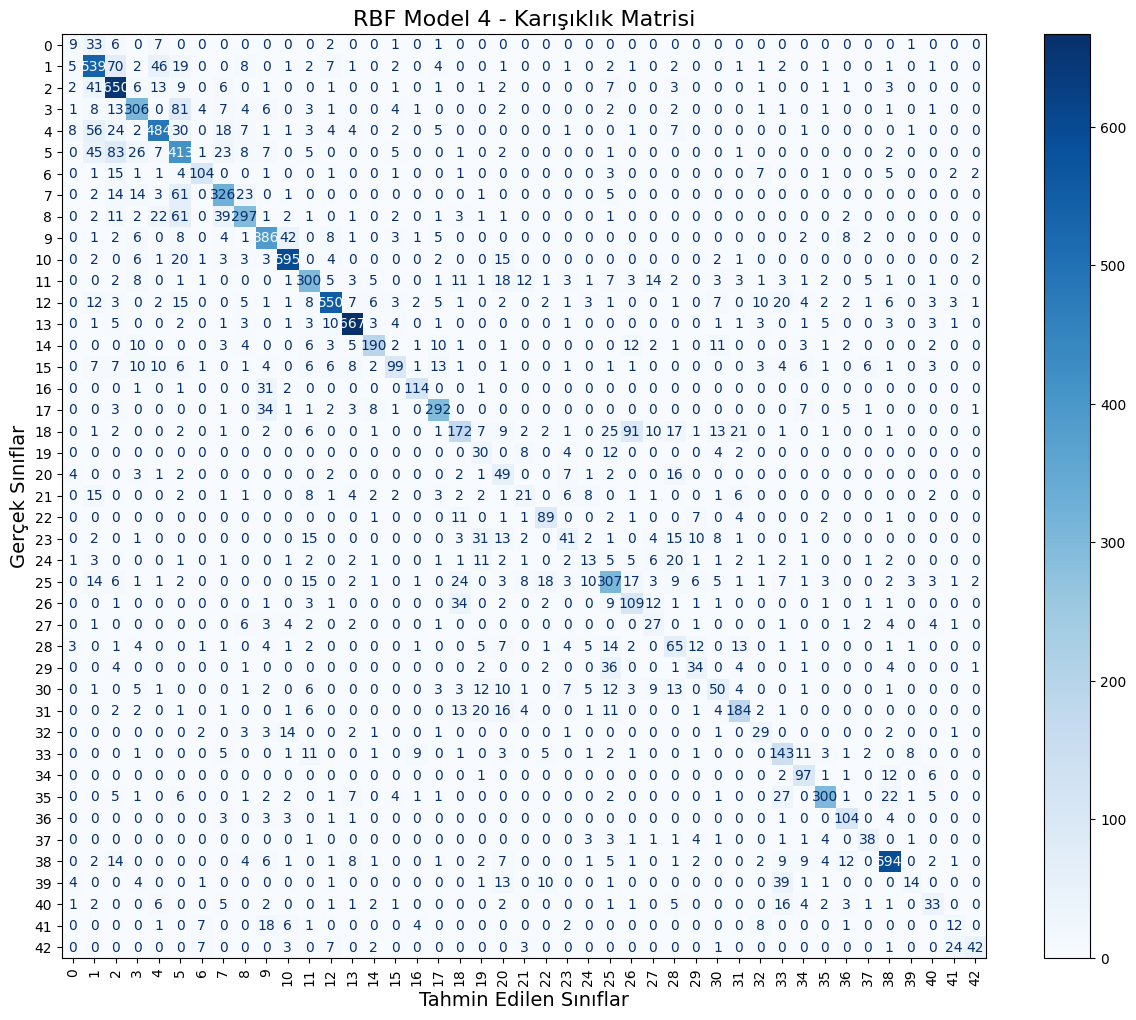

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Test seti üzerinde tahminler yap
y_pred_encoded = random_search_rbf4.best_estimator_.predict(X_test_scaled)

# One-hot encoded sınıfları argmax ile geri dönüştür
y_test_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred_encoded, axis=1)

# Karışıklık matrisini hesapla
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Karışıklık matrisini görselleştir
fig, ax = plt.subplots(figsize=(15, 12))  # Boyutları daha büyük ayarlandı
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', colorbar=True)

plt.title("RBF Model 4 - Karışıklık Matrisi", fontsize=16)
plt.xlabel("Tahmin Edilen Sınıflar", fontsize=14)
plt.ylabel("Gerçek Sınıflar", fontsize=14)
plt.show()


**Sonuç olarak:**

RBF Model 4 modelinde çoğunlukla doğru sınıflara yoğunlaştığını, ancak bazı sınıflar arasında karışıklık yaşadığını gözlemlemekteyiz.

•	Diagonal boyunca yoğunluk, modelin bize doğru tahminlerde bulunduğunu gösteriyor.

•	Ancak, bazı sınıflarda (örneğin, 7, 10, 33) yanlış tahminler daha fazla görülmektedir.

•	Genel performans iyileşmiş, ancak model bazı sınıflarda dengesizlik yaşıyor.
Model performansını artırmak için bir önceki modelde olduğu gibi sınıf dengesini sağlayabiliriz ya da hiperparametre optimizasyonu ile daha fazla iyileştirmeyi dneeyebiliriz.
